Columns in the dataset:
Index(['species', 'island', 'culmen_length_mm', 'culmen_depth_mm',
       'flipper_length_mm', 'body_mass_g', 'sex'],
      dtype='object')

First 5 rows of the dataset:
  species     island  culmen_length_mm  culmen_depth_mm  flipper_length_mm  \
0  Adelie  Torgersen              39.1             18.7              181.0   
1  Adelie  Torgersen              39.5             17.4              186.0   
2  Adelie  Torgersen              40.3             18.0              195.0   
3  Adelie  Torgersen               NaN              NaN                NaN   
4  Adelie  Torgersen              36.7             19.3              193.0   

   body_mass_g     sex  
0       3750.0    MALE  
1       3800.0  FEMALE  
2       3250.0  FEMALE  
3          NaN     NaN  
4       3450.0  FEMALE  

Summary Statistics:
       culmen_length_mm  culmen_depth_mm  flipper_length_mm  body_mass_g
count        342.000000       342.000000         342.000000   342.000000
mean          43.921

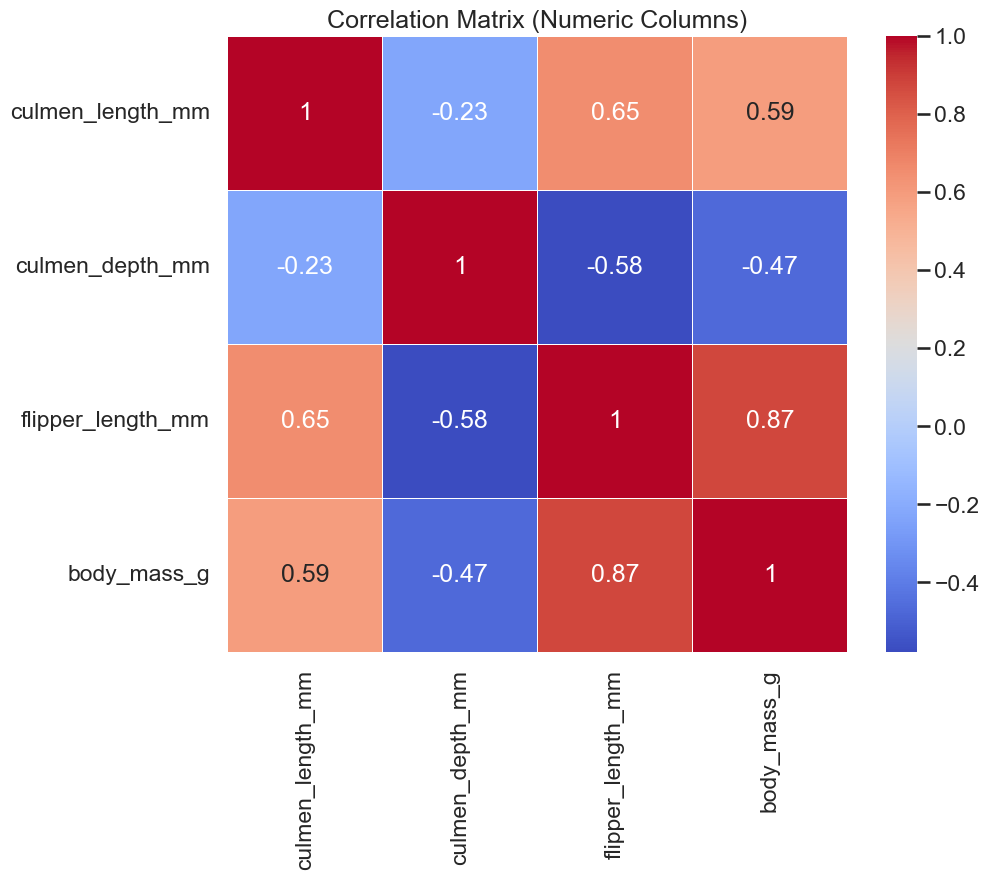

In [22]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =============================
# 1. Data Loading & EDA
# =============================

# Set the path to your dataset
data_path = "data/penguins_size.csv"

# Load the dataset
df = pd.read_csv(data_path)

print("Columns in the dataset:")
print(df.columns)

# Display first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Display summary statistics
print("\nSummary Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values per Column:")
print(df.isnull().sum())

# Clean Data: Remove rows with missing values
df_clean = df.dropna()
print("\nShape after cleaning:", df_clean.shape)

# -----------------------------
# Correlation Matrix (Only Numeric Features)
# -----------------------------
plt.figure(figsize=(10, 8))
# Select only numeric columns (this excludes 'species', 'island', and 'sex')
df_numeric = df_clean.select_dtypes(include=[np.number])
corr_matrix = df_numeric.corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix (Numeric Columns)")
plt.show()


## Clustering sin PCA + KMeans

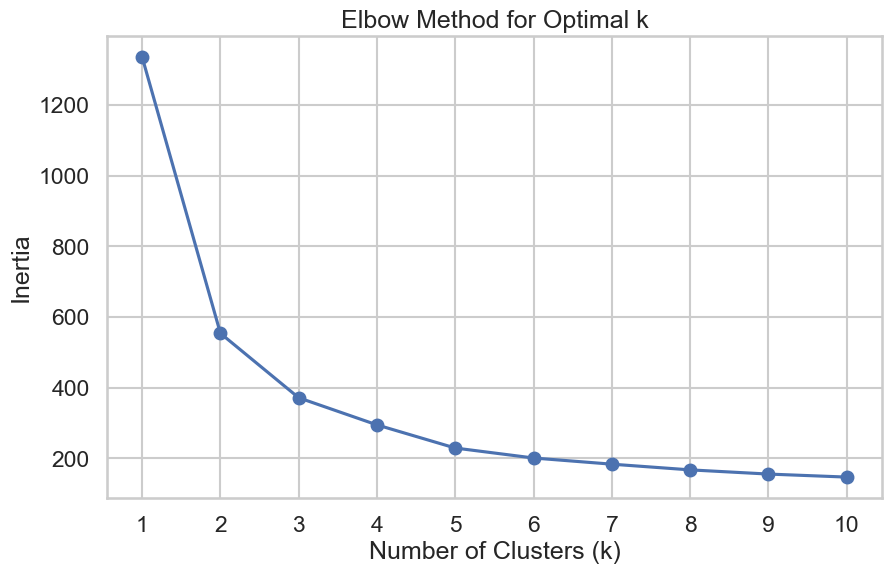


Clustering Evaluation Metrics:
Silhouette Score: 0.447
Davies-Bouldin Index: 0.942
Inertia: 371.757


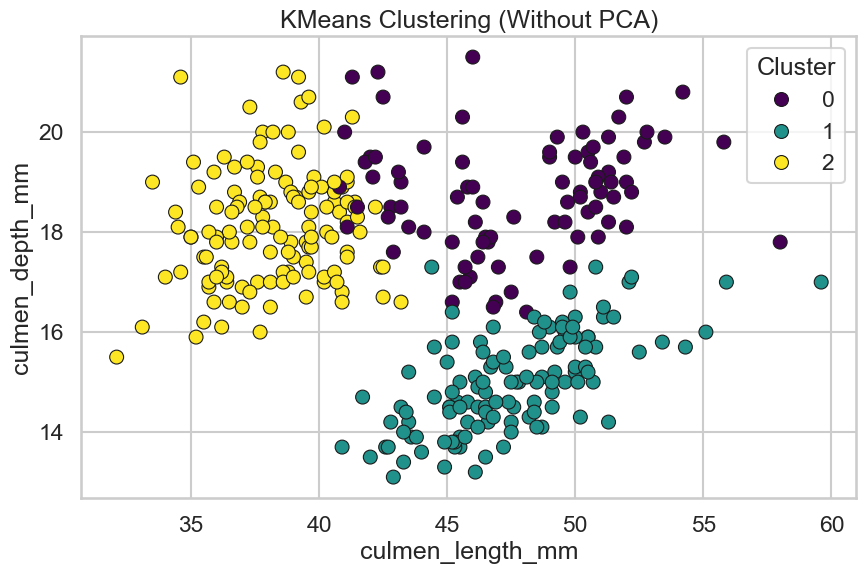

In [23]:
# =============================================================================
# 2. Branch 1: KMeans Clustering WITHOUT PCA
# =============================================================================

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Use the numeric columns from the cleaned dataset
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
data_numeric = df_clean[numeric_cols]

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# -----------------------------
# Determine Optimal Number of Clusters using the Elbow Method
# -----------------------------
inertia_values = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(data_scaled)
    inertia_values.append(km.inertia_)

plt.figure(figsize=(10,6))
plt.plot(k_range, inertia_values, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.xticks(k_range)
plt.show()

# -----------------------------
# Apply KMeans (without PCA) - choose optimal_k (e.g., 3)
# -----------------------------
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(data_scaled)

# -----------------------------
# Evaluate Clustering Performance
# -----------------------------
silhouette = silhouette_score(data_scaled, cluster_labels)
davies_bouldin = davies_bouldin_score(data_scaled, cluster_labels)

print("\nClustering Evaluation Metrics:")
print(f"Silhouette Score: {silhouette:.3f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.3f}")
print(f"Inertia: {kmeans.inertia_:.3f}")

# -----------------------------
# Visualize Clusters using two chosen original features
# (Here we use 'culmen_length_mm' vs 'culmen_depth_mm')
# -----------------------------
plt.figure(figsize=(10,6))
sns.scatterplot(x=data_numeric['culmen_length_mm'], y=data_numeric['culmen_depth_mm'],
                hue=cluster_labels, palette='viridis', s=100, edgecolor='k')
plt.xlabel("culmen_length_mm")
plt.ylabel("culmen_depth_mm")
plt.title("KMeans Clustering (Without PCA)")
plt.legend(title="Cluster")
plt.show()



## Clustering con PCA + KMeans


Explained Variance for each Principal Component (All Components):
PC1: 68.64%
PC2: 19.45%
PC3: 9.22%
PC4: 2.69%

Cumulative Explained Variance:
Up to PC1: 68.64%
Up to PC2: 88.09%
Up to PC3: 97.31%
Up to PC4: 100.00%


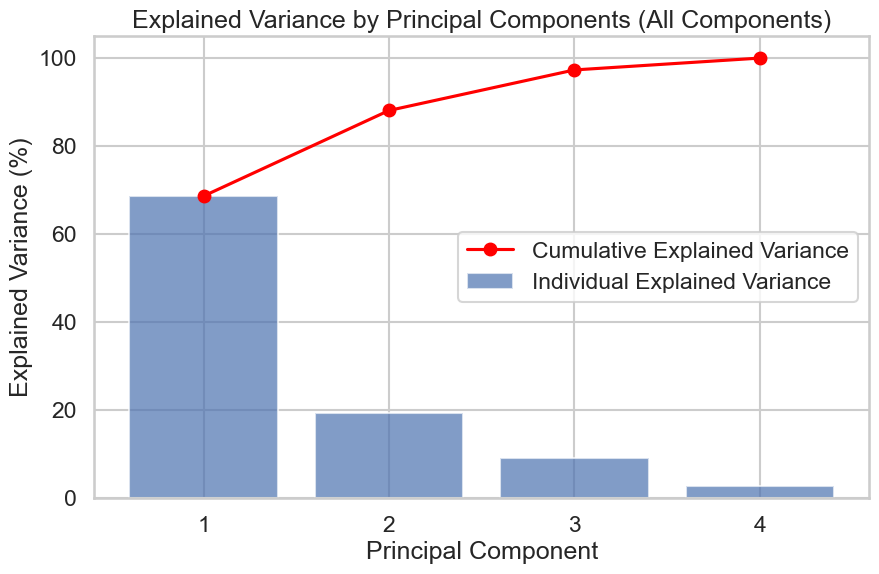


Explained Variance for 2-Component PCA (for clustering visualization):
PC1: 68.64%, PC2: 19.45%


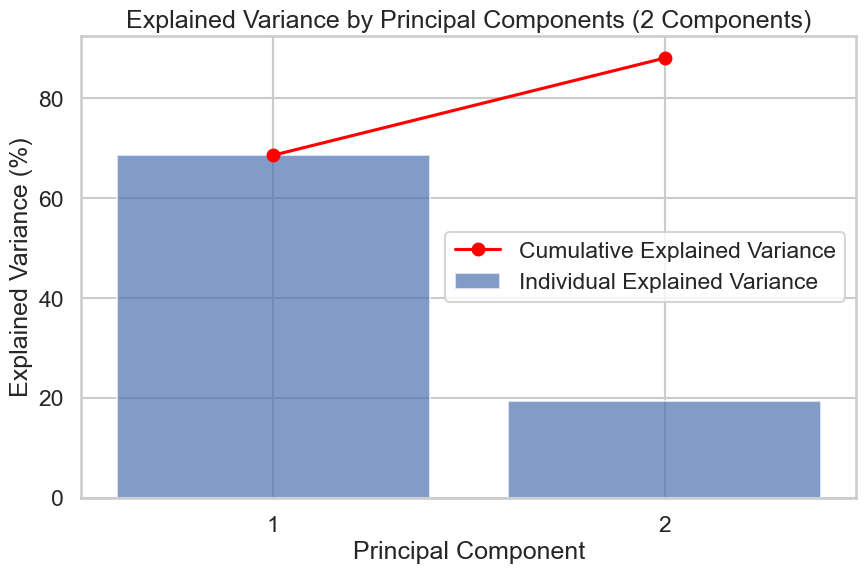

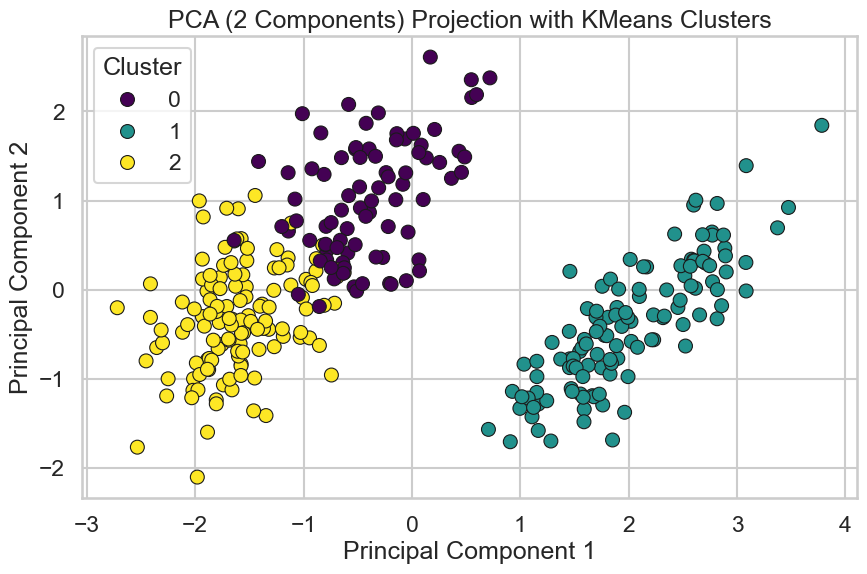

In [24]:
# =============================================================================
# 3. Branch 2: KMeans Clustering WITH PCA (Full PCA Analysis)
# =============================================================================

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# We reuse 'data_scaled' from the previous branch

# -----------------------------
# Apply KMeans on standardized data (using the same optimal_k)
# -----------------------------
optimal_k = 3  # (this value was chosen based on the Elbow Method in Branch 1)
kmeans_pca = KMeans(n_clusters=optimal_k, n_init=10, random_state=42)
cluster_labels_pca = kmeans_pca.fit_predict(data_scaled)

# -----------------------------
# Apply PCA using ALL components (to capture 100% of variance)
# -----------------------------
pca_full = PCA()  # By default, n_components=None returns all components
pca_full_components = pca_full.fit_transform(data_scaled)

# Calculate explained variance for each component and the cumulative variance
explained_variance_full = pca_full.explained_variance_ratio_
cumulative_variance_full = np.cumsum(explained_variance_full)

print("\nExplained Variance for each Principal Component (All Components):")
for i, ev in enumerate(explained_variance_full):
    print(f"PC{i+1}: {ev*100:.2f}%")
    
print("\nCumulative Explained Variance:")
for i, cum in enumerate(cumulative_variance_full):
    print(f"Up to PC{i+1}: {cum*100:.2f}%")

# Plot the explained variance for all components
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_full)+1), explained_variance_full*100, 
        alpha=0.7, label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_variance_full)+1), cumulative_variance_full*100, 
         marker='o', color='red', label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance by Principal Components (All Components)')
plt.xticks(range(1, len(explained_variance_full)+1))
plt.legend()
plt.show()

# -----------------------------
# Additionally, perform PCA with 2 components for visualization purposes
# -----------------------------
pca_2 = PCA(n_components=2)
pca_2_components = pca_2.fit_transform(data_scaled)

explained_variance_2 = pca_2.explained_variance_ratio_
print("\nExplained Variance for 2-Component PCA (for clustering visualization):")
print(f"PC1: {explained_variance_2[0]*100:.2f}%, PC2: {explained_variance_2[1]*100:.2f}%")

cumulative_variance_2 = np.cumsum(explained_variance_2)
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_2)+1), explained_variance_2*100, alpha=0.7, 
        label='Individual Explained Variance')
plt.plot(range(1, len(cumulative_variance_2)+1), cumulative_variance_2*100, marker='o', 
         color='red', label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance (%)')
plt.title('Explained Variance by Principal Components (2 Components)')
plt.xticks(range(1, len(explained_variance_2)+1))
plt.legend()
plt.show()

# -----------------------------
# Visualize PCA Projection with KMeans Clusters (2D projection)
# -----------------------------
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_2_components[:, 0], y=pca_2_components[:, 1],
                hue=cluster_labels_pca, palette='viridis', s=100, edgecolor='k')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA (2 Components) Projection with KMeans Clusters")
plt.legend(title="Cluster")
plt.show()
